<a href="https://colab.research.google.com/github/Ranuki-02/Handsign-recognition2025/blob/main/test3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
# Import all necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import zipfile
import shutil
from collections import Counter


In [3]:
# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [4]:
# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder


In [5]:
# Utilities
import warnings
warnings.filterwarnings('ignore')


In [6]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [7]:
# Step 1: Upload kaggle.json
from google.colab import files
files.upload()   # Browse and upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ranukidasanayaka","key":"726fff4162dff6cd85e789c96beca649"}'}

In [8]:
# Step 2: Make a directory for Kaggle and move kaggle.json there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [9]:
# Step 3: Give proper permissions
!chmod 600 ~/.kaggle/kaggle.json


In [11]:
# Set up Kaggle API credentials
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

# Create kaggle directory and copy credentials
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("🔑 Kaggle credentials configured!")

# Download the dataset
dataset_name = "jeyasrisenthil/hand-signs-asl-hand-sign-data"
!kaggle datasets download -d {dataset_name}

🔑 Kaggle credentials configured!
Dataset URL: https://www.kaggle.com/datasets/jeyasrisenthil/hand-signs-asl-hand-sign-data
License(s): DbCL-1.0
  0% 0.00/17.5M [00:00<?, ?B/s]
100% 17.5M/17.5M [00:00<00:00, 1.16GB/s]


In [12]:
# Extract the dataset
zip_file = "hand-signs-asl-hand-sign-data.zip"
extract_path = "/content/hand_signs_data"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("📂 Dataset downloaded and extracted successfully!")


📂 Dataset downloaded and extracted successfully!


In [13]:
# Explore the dataset structure
def explore_directory_structure(path, max_depth=3, current_depth=0):
    """Explore and display directory structure"""
    items = []
    if current_depth < max_depth:
        try:
            for item in sorted(os.listdir(path)):
                item_path = os.path.join(path, item)
                indent = "  " * current_depth
                if os.path.isdir(item_path):
                    items.append(f"{indent}📁 {item}/")
                    items.extend(explore_directory_structure(item_path, max_depth, current_depth + 1))
                else:
                    items.append(f"{indent}📄 {item}")
        except PermissionError:
            items.append(f"{indent}❌ Permission denied")
    return items

print("\n🔍 Dataset structure:")
structure = explore_directory_structure(extract_path)
for item in structure[:20]:  # Show first 20 items
    print(item)


🔍 Dataset structure:
📁 DATASET/
  📁 0/
    📄 image_1681392938.561891.jpg
    📄 image_1681392945.9290903.jpg
    📄 image_1681392952.1047366.jpg
    📄 image_1681392958.561848.jpg
    📄 image_1681392968.506309.jpg
    📄 image_1681392988.5740635.jpg
    📄 image_1681393000.6386273.jpg
    📄 image_1681393041.6576877.jpg
    📄 image_1681393047.2098856.jpg
    📄 image_1681393053.5109465.jpg
    📄 image_1681393068.4097507.jpg
    📄 image_1681393090.0752842.jpg
    📄 image_1681393097.4192748.jpg
    📄 image_1681393109.4386442.jpg
    📄 image_1681393124.4695137.jpg
    📄 image_1681393160.7460952.jpg
    📄 image_1681393184.638091.jpg
    📄 image_1681393215.0710337.jpg


In [14]:
# STEP 3: DATA PREPROCESSING AND EXPLORATION
# ================================================================================

# Find the actual data directory (it might be nested)
def find_image_directories(base_path):
    """Find directories containing image files"""
    image_dirs = []
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')

    for root, dirs, files in os.walk(base_path):
        image_files = [f for f in files if f.lower().endswith(image_extensions)]
        if image_files and not dirs:  # Leaf directory with images
            image_dirs.append(root)

    return image_dirs

In [15]:
# Find image directories
image_dirs = find_image_directories(extract_path)
print(f"\n🖼️ Found {len(image_dirs)} image directories:")
for dir_path in image_dirs:
    class_name = os.path.basename(dir_path)
    num_images = len([f for f in os.listdir(dir_path)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
    print(f"  {class_name}: {num_images} images")



🖼️ Found 36 image directories:
  K: 25 images
  0: 25 images
  Q: 25 images
  A: 25 images
  G: 25 images
  T: 25 images
  2: 25 images
  W: 25 images
  V: 25 images
  D: 25 images
  1: 25 images
  L: 25 images
  9: 25 images
  3: 25 images
  M: 25 images
  8: 25 images
  R: 25 images
  P: 25 images
  B: 25 images
  X: 25 images
  E: 25 images
  J: 25 images
  Z: 25 images
  C: 25 images
  H: 25 images
  N: 25 images
  F: 25 images
  U: 25 images
  I: 25 images
  6: 25 images
  4: 25 images
  5: 25 images
  S: 25 images
  7: 25 images
  O: 25 images
  Y: 25 images


In [16]:
# Set data directory (modify this path based on your dataset structure)
# Common paths for this dataset:
possible_paths = [
    os.path.join(extract_path, "asl_alphabet_train"),
    os.path.join(extract_path, "train"),
    os.path.join(extract_path, "Train"),
    extract_path
]

data_dir = None
for path in possible_paths:
    if os.path.exists(path) and len(find_image_directories(path)) > 0:
        data_dir = path
        break

if data_dir is None:
    # If we can't find the standard structure, use the first directory with subdirs
    for root, dirs, files in os.walk(extract_path):
        if dirs and any(os.path.isdir(os.path.join(root, d)) for d in dirs):
            data_dir = root
            break

print(f"📁 Using data directory: {data_dir}")

📁 Using data directory: /content/hand_signs_data


In [17]:
# Get all class names and count images
def get_class_info(data_path):
    """Get class information and image counts"""
    class_info = {}
    total_images = 0

    for class_name in sorted(os.listdir(data_path)):
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            class_info[class_name] = len(image_files)
            total_images += len(image_files)

    return class_info, total_images

class_info, total_images = get_class_info(data_dir)
print(f"\n📊 Dataset Summary:")
print(f"Total classes: {len(class_info)}")
print(f"Total images: {total_images}")
print(f"Classes: {list(class_info.keys())}")



📊 Dataset Summary:
Total classes: 1
Total images: 0
Classes: ['DATASET']


In [18]:
# STEP 4: DATA VISUALIZATION
# ================================================================================

def visualize_sample_images(data_dir, classes, samples_per_class=3, figsize=(15, 10)):
    """Visualize sample images from each class"""
    fig, axes = plt.subplots(len(classes), samples_per_class, figsize=figsize)
    fig.suptitle('Sample Hand Sign Images by Class', fontsize=16, fontweight='bold')

    for i, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        if os.path.exists(class_path):
            image_files = [f for f in os.listdir(class_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

            for j in range(min(samples_per_class, len(image_files))):
                img_path = os.path.join(class_path, image_files[j])
                try:
                    img = load_img(img_path, target_size=(64, 64))

                    if len(classes) > 1:
                        ax = axes[i, j]
                    else:
                        ax = axes[j]

                    ax.imshow(img)
                    ax.axis('off')
                    if j == 0:
                        ax.set_ylabel(f'Class: {class_name}', fontsize=12, fontweight='bold')
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

    plt.tight_layout()
    plt.show()


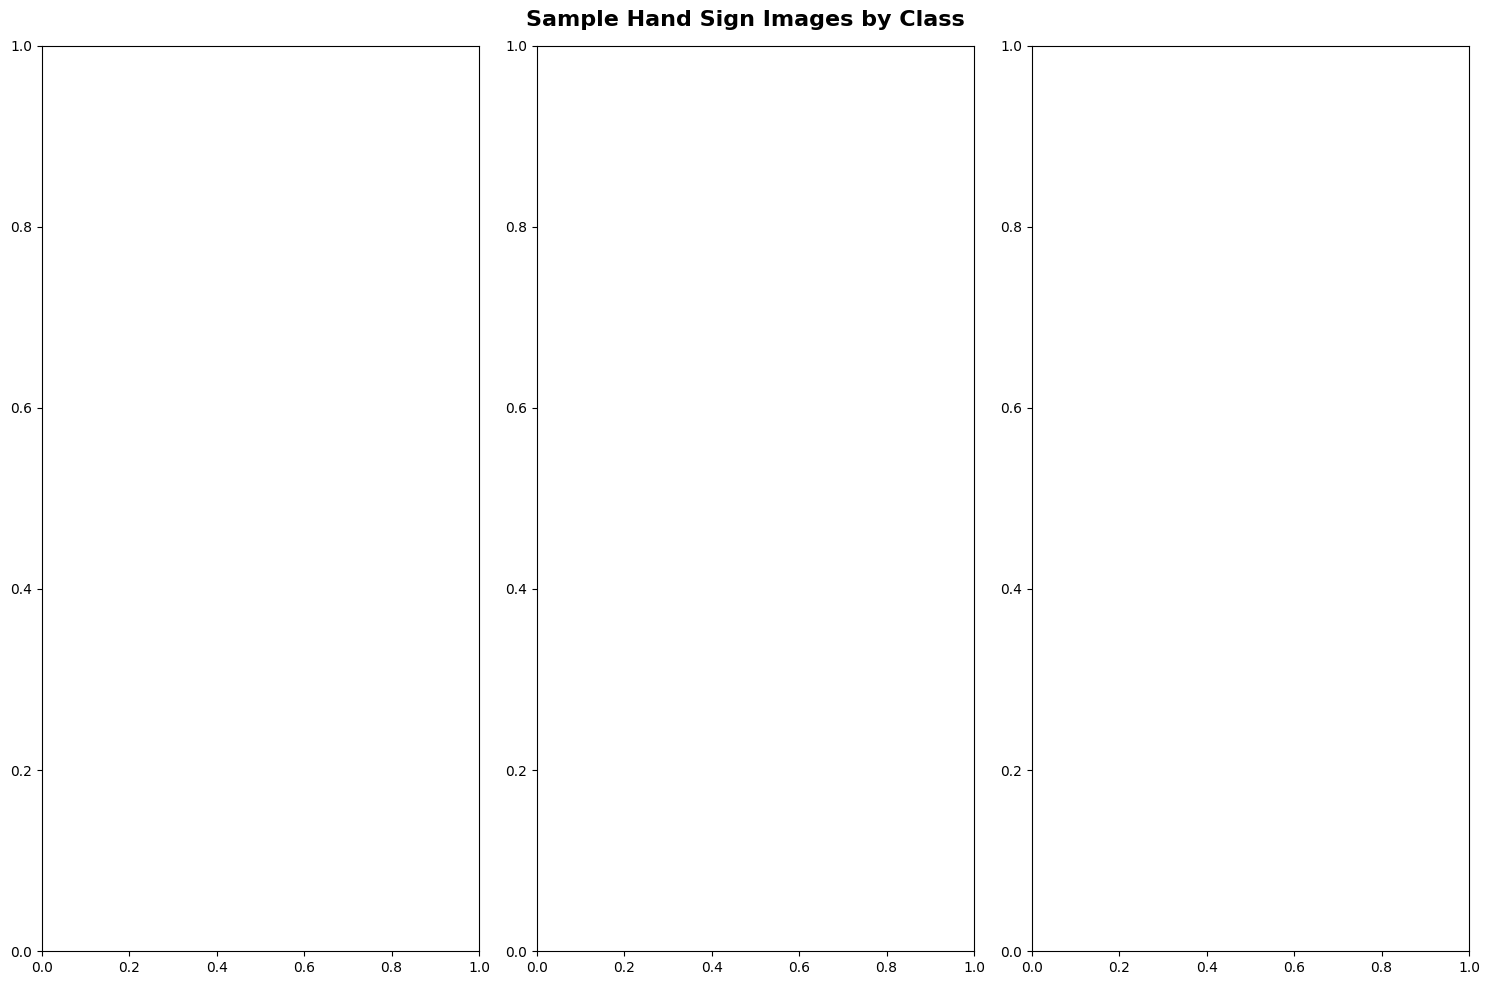

In [19]:
# Show sample images (limit to first 8 classes for visualization)
sample_classes = list(class_info.keys())[:8]
visualize_sample_images(data_dir, sample_classes)


In [20]:
import os

print("Data directory:", data_dir)
for cls in sample_classes:
    cls_path = os.path.join(data_dir, cls)
    print(cls, "->", len(os.listdir(cls)), "files")


Data directory: /content/hand_signs_data


FileNotFoundError: [Errno 2] No such file or directory: 'DATASET'

In [21]:
import os
print(os.listdir("/content"))


['.config', 'hand_signs_data', 'hand-signs-asl-hand-sign-data.zip', 'kaggle.json', 'sample_data']


In [22]:
data_dir = "/content/<hand-signs-asl-hand-sign-data.zip>"


In [25]:
from google.colab import files

uploaded = files.upload()   # Choose your .zip dataset from your computer


Saving archive.zip to archive.zip


In [26]:
import zipfile
import os

# Specify the path to the uploaded zip file
zip_file_path = 'archive.zip'

# Specify the directory where you want to extract the contents
extract_dir = 'extracted_dataset'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"'{zip_file_path}' extracted to '{extract_dir}' successfully!")

'archive.zip' extracted to 'extracted_dataset' successfully!


In [28]:
# Your extracted dataset path
dataset_path = 'extracted_dataset'  # This matches your extraction directory

print(f"🔍 Exploring dataset structure in: {dataset_path}")

def explore_directory_structure(path, max_depth=3, current_depth=0):
    """Explore and display directory structure"""
    items = []
    if current_depth < max_depth and os.path.exists(path):
        try:
            for item in sorted(os.listdir(path)):
                item_path = os.path.join(path, item)
                indent = "  " * current_depth
                if os.path.isdir(item_path):
                    items.append(f"{indent}📁 {item}/")
                    items.extend(explore_directory_structure(item_path, max_depth, current_depth + 1))
                else:
                    # Show file extension for better understanding
                    ext = os.path.splitext(item)[1].lower()
                    if ext in ['.jpg', '.jpeg', '.png', '.bmp', '.gif']:
                        items.append(f"{indent}🖼️ {item}")
                    else:
                        items.append(f"{indent}📄 {item}")
        except PermissionError:
            items.append(f"{indent}❌ Permission denied")
    return items

# Display the directory structure
structure = explore_directory_structure(dataset_path)
for item in structure:
    print(item)

🔍 Exploring dataset structure in: extracted_dataset
📁 DATASET/
  📁 0/
    🖼️ image_1681392938.561891.jpg
    🖼️ image_1681392945.9290903.jpg
    🖼️ image_1681392952.1047366.jpg
    🖼️ image_1681392958.561848.jpg
    🖼️ image_1681392968.506309.jpg
    🖼️ image_1681392988.5740635.jpg
    🖼️ image_1681393000.6386273.jpg
    🖼️ image_1681393041.6576877.jpg
    🖼️ image_1681393047.2098856.jpg
    🖼️ image_1681393053.5109465.jpg
    🖼️ image_1681393068.4097507.jpg
    🖼️ image_1681393090.0752842.jpg
    🖼️ image_1681393097.4192748.jpg
    🖼️ image_1681393109.4386442.jpg
    🖼️ image_1681393124.4695137.jpg
    🖼️ image_1681393160.7460952.jpg
    🖼️ image_1681393184.638091.jpg
    🖼️ image_1681393215.0710337.jpg
    🖼️ image_1681393221.8511162.jpg
    🖼️ image_1681393258.5744524.jpg
    🖼️ image_1681393298.875819.jpg
    🖼️ image_1681393343.2362373.jpg
    🖼️ image_1681393350.9875703.jpg
    🖼️ image_1681393360.6992092.jpg
    🖼️ image_1681393369.884183.jpg
  📁 1/
    🖼️ image_1681399987.77893

In [29]:
# Show dataset structure
if os.path.exists(dataset_path):
    print("\n📂 Dataset structure:")
    structure = explore_directory_structure(dataset_path)
    for item in structure:
        print(item)
else:
    print(f"❌ Dataset path '{dataset_path}' not found!")
    print("Available directories in current folder:")
    for item in os.listdir('.'):
        if os.path.isdir(item):
            print(f"  📁 {item}/")


📂 Dataset structure:
📁 DATASET/
  📁 0/
    🖼️ image_1681392938.561891.jpg
    🖼️ image_1681392945.9290903.jpg
    🖼️ image_1681392952.1047366.jpg
    🖼️ image_1681392958.561848.jpg
    🖼️ image_1681392968.506309.jpg
    🖼️ image_1681392988.5740635.jpg
    🖼️ image_1681393000.6386273.jpg
    🖼️ image_1681393041.6576877.jpg
    🖼️ image_1681393047.2098856.jpg
    🖼️ image_1681393053.5109465.jpg
    🖼️ image_1681393068.4097507.jpg
    🖼️ image_1681393090.0752842.jpg
    🖼️ image_1681393097.4192748.jpg
    🖼️ image_1681393109.4386442.jpg
    🖼️ image_1681393124.4695137.jpg
    🖼️ image_1681393160.7460952.jpg
    🖼️ image_1681393184.638091.jpg
    🖼️ image_1681393215.0710337.jpg
    🖼️ image_1681393221.8511162.jpg
    🖼️ image_1681393258.5744524.jpg
    🖼️ image_1681393298.875819.jpg
    🖼️ image_1681393343.2362373.jpg
    🖼️ image_1681393350.9875703.jpg
    🖼️ image_1681393360.6992092.jpg
    🖼️ image_1681393369.884183.jpg
  📁 1/
    🖼️ image_1681399987.7789311.jpg
    🖼️ image_1681399992

In [30]:
# STEP 3: FIND AND ANALYZE IMAGE DIRECTORIES
# ================================================================================

def find_image_directories(base_path):
    """Find directories containing image files"""
    image_dirs = []
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.webp')

    if not os.path.exists(base_path):
        print(f"❌ Path {base_path} does not exist!")
        return image_dirs

    for root, dirs, files in os.walk(base_path):
        image_files = [f for f in files if f.lower().endswith(image_extensions)]
        if image_files:
            # Count subdirectories
            subdirs = [d for d in dirs if os.path.isdir(os.path.join(root, d))]
            image_dirs.append({
                'path': root,
                'image_count': len(image_files),
                'has_subdirs': len(subdirs) > 0,
                'is_leaf': len(subdirs) == 0
            })

    return image_dirs

In [31]:
# Find all directories with images
image_dirs = find_image_directories(dataset_path)

print(f"\n🖼️ Found {len(image_dirs)} directories with images:")
for dir_info in image_dirs:
    rel_path = os.path.relpath(dir_info['path'], dataset_path)
    status = "🌿 (leaf)" if dir_info['is_leaf'] else "🌳 (has subdirs)"
    print(f"  {rel_path}: {dir_info['image_count']} images {status}")


🖼️ Found 36 directories with images:
  DATASET/K: 25 images 🌿 (leaf)
  DATASET/0: 25 images 🌿 (leaf)
  DATASET/Q: 25 images 🌿 (leaf)
  DATASET/A: 25 images 🌿 (leaf)
  DATASET/G: 25 images 🌿 (leaf)
  DATASET/T: 25 images 🌿 (leaf)
  DATASET/2: 25 images 🌿 (leaf)
  DATASET/W: 25 images 🌿 (leaf)
  DATASET/V: 25 images 🌿 (leaf)
  DATASET/D: 25 images 🌿 (leaf)
  DATASET/1: 25 images 🌿 (leaf)
  DATASET/L: 25 images 🌿 (leaf)
  DATASET/9: 25 images 🌿 (leaf)
  DATASET/3: 25 images 🌿 (leaf)
  DATASET/M: 25 images 🌿 (leaf)
  DATASET/8: 25 images 🌿 (leaf)
  DATASET/R: 25 images 🌿 (leaf)
  DATASET/P: 25 images 🌿 (leaf)
  DATASET/B: 25 images 🌿 (leaf)
  DATASET/X: 25 images 🌿 (leaf)
  DATASET/E: 25 images 🌿 (leaf)
  DATASET/J: 25 images 🌿 (leaf)
  DATASET/Z: 25 images 🌿 (leaf)
  DATASET/C: 25 images 🌿 (leaf)
  DATASET/H: 25 images 🌿 (leaf)
  DATASET/N: 25 images 🌿 (leaf)
  DATASET/F: 25 images 🌿 (leaf)
  DATASET/U: 25 images 🌿 (leaf)
  DATASET/I: 25 images 🌿 (leaf)
  DATASET/6: 25 images 🌿 (leaf)
  

In [32]:
# STEP 4: DETERMINE DATA DIRECTORY STRUCTURE
# ================================================================================

# Find the best data directory (usually leaf directories are class folders)
leaf_dirs = [d for d in image_dirs if d['is_leaf']]

if leaf_dirs:
    print(f"\n✅ Found {len(leaf_dirs)} leaf directories (likely class folders)")

    # Determine the data root directory
    # Find common parent of all leaf directories
    leaf_paths = [d['path'] for d in leaf_dirs]
    common_parent = os.path.commonpath(leaf_paths) if len(leaf_paths) > 1 else os.path.dirname(leaf_paths[0])

    data_dir = common_parent
    print(f"📁 Using data directory: {data_dir}")

    # Get class information
    class_info = {}
    for dir_info in leaf_dirs:
        class_name = os.path.basename(dir_info['path'])
        class_info[class_name] = dir_info['image_count']

else:
    print("⚠️ No clear leaf directories found. Checking all directories with images...")
    # Use the directory with the most subdirectories containing images
    if image_dirs:
        data_dir = image_dirs[0]['path']  # Use first directory as fallback
        print(f"📁 Using data directory: {data_dir}")

        # Try to get class info from subdirectories
        class_info = {}
        for subdir in os.listdir(data_dir):
            subdir_path = os.path.join(data_dir, subdir)
            if os.path.isdir(subdir_path):
                image_files = [f for f in os.listdir(subdir_path)
                             if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
                if image_files:
                    class_info[subdir] = len(image_files)
    else:
        print("❌ No image directories found!")
        data_dir = None
        class_info = {}

# Display class information
if class_info:
    total_images = sum(class_info.values())
    print(f"\n📊 Dataset Summary:")
    print(f"Total classes: {len(class_info)}")
    print(f"Total images: {total_images}")
    print(f"Classes: {list(class_info.keys())}")

else:
    print("\n❌ Could not determine class information.")
    print("Please check the dataset structure and the `find_image_directories` function.")


✅ Found 36 leaf directories (likely class folders)
📁 Using data directory: extracted_dataset/DATASET

📊 Dataset Summary:
Total classes: 36
Total images: 900
Classes: ['K', '0', 'Q', 'A', 'G', 'T', '2', 'W', 'V', 'D', '1', 'L', '9', '3', 'M', '8', 'R', 'P', 'B', 'X', 'E', 'J', 'Z', 'C', 'H', 'N', 'F', 'U', 'I', '6', '4', '5', 'S', '7', 'O', 'Y']


In [34]:
# STEP 5: VISUALIZE SAMPLE IMAGES
# ================================================================================

def visualize_sample_images(data_dir, class_info, samples_per_class=3, max_classes=8):
    """Visualize sample images from each class"""

    classes_to_show = list(class_info.keys())[:max_classes]  # Limit for better visualization

    fig, axes = plt.subplots(len(classes_to_show), samples_per_class,
                            figsize=(15, 3*len(classes_to_show)))

    if len(classes_to_show) == 1:
        axes = axes.reshape(1, -1)
    elif samples_per_class == 1:
        axes = axes.reshape(-1, 1)

    fig.suptitle('Sample Hand Sign Images by Class', fontsize=16, fontweight='bold')

    for i, class_name in enumerate(classes_to_show):
        class_path = os.path.join(data_dir, class_name)
        if os.path.exists(class_path):
            # Get image files
            image_files = [f for f in os.listdir(class_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]

            for j in range(samples_per_class):
                if j < len(image_files):
                    img_path = os.path.join(class_path, image_files[j])
                    try:
                        img = load_img(img_path, target_size=(64, 64))

                        ax = axes[i, j] if len(classes_to_show) > 1 else axes[j]
                        ax.imshow(img)
                        ax.axis('off')

                        if j == 0:  # Add class name to first image
                            ax.set_ylabel(f'{class_name}\n({class_info[class_name]} imgs)',
                                        fontsize=10, fontweight='bold')
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
                        ax = axes[i, j] if len(classes_to_show) > 1 else axes[j]
                        ax.axis('off') # Ensure axis is off even on error

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
    plt.show()

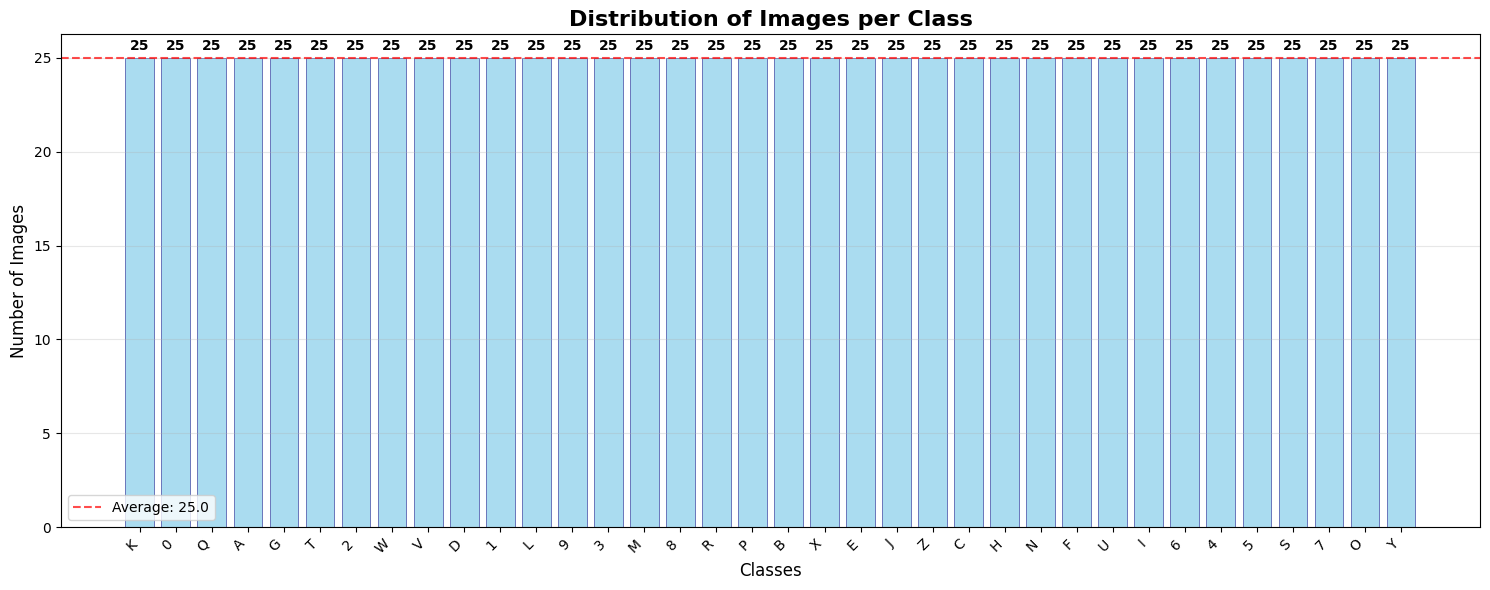


📈 Distribution Statistics:
Minimum images per class: 25
Maximum images per class: 25
Average images per class: 25.0
Standard deviation: 0.0


In [35]:
# STEP 6: VISUALIZE CLASS DISTRIBUTION
# ================================================================================

if class_info:
    plt.figure(figsize=(15, 6))
    classes = list(class_info.keys())
    counts = list(class_info.values())

    # Create bar plot
    bars = plt.bar(classes, counts, color='skyblue', alpha=0.7, edgecolor='navy', linewidth=0.5)

    plt.title('Distribution of Images per Class', fontsize=16, fontweight='bold')
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Add count labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                str(count), ha='center', va='bottom', fontweight='bold')

    # Add statistics
    avg_count = np.mean(counts)
    plt.axhline(y=avg_count, color='red', linestyle='--', alpha=0.7,
                label=f'Average: {avg_count:.1f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"\n📈 Distribution Statistics:")
    print(f"Minimum images per class: {min(counts)}")
    print(f"Maximum images per class: {max(counts)}")
    print(f"Average images per class: {np.mean(counts):.1f}")
    print(f"Standard deviation: {np.std(counts):.1f}")

In [36]:
# STEP 7: LOAD AND PREPROCESS DATA
# ================================================================================

# Configuration
IMG_HEIGHT, IMG_WIDTH = 64, 64  # Resize all images to 64x64
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 0.001

def load_and_preprocess_data(data_dir, class_info, img_height=64, img_width=64):
    """Load and preprocess all images and labels"""
    images = []
    labels = []

    print("🔄 Loading and preprocessing images...")

    total_images = sum(class_info.values())
    processed_count = 0

    for class_name, expected_count in class_info.items():
        class_path = os.path.join(data_dir, class_name)

        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]

            print(f"Processing {class_name}: {len(image_files)} images")

            for img_file in image_files:
                try:
                    img_path = os.path.join(class_path, img_file)

                    # Load and resize image
                    img = load_img(img_path, target_size=(img_height, img_width))
                    img_array = img_to_array(img) / 255.0  # Normalize to [0,1]

                    images.append(img_array)
                    labels.append(class_name)

                    processed_count += 1

                    # Progress indicator
                    if processed_count % 100 == 0 or processed_count == total_images:
                        print(f"  Processed: {processed_count}/{total_images} images")

                except Exception as e:
                    print(f"  ⚠️ Error processing {img_path}: {e}")

    return np.array(images), np.array(labels)

# Load all data if we have a valid dataset
if class_info and data_dir:
    X, y = load_and_preprocess_data(data_dir, class_info, IMG_HEIGHT, IMG_WIDTH)
    class_names = sorted(list(class_info.keys()))

    print(f"\n✅ Data loading completed!")
    print(f"📏 Images shape: {X.shape}")
    print(f"🏷️ Labels shape: {y.shape}")
    print(f"🎯 Number of classes: {len(class_names)}")
    print(f"📝 Class names: {class_names}")
else:
    print("❌ Cannot load data - invalid dataset structure")
    X, y, class_names = None, None, None


🔄 Loading and preprocessing images...
Processing K: 25 images
Processing 0: 25 images
Processing Q: 25 images
Processing A: 25 images
  Processed: 100/900 images
Processing G: 25 images
Processing T: 25 images
Processing 2: 25 images
Processing W: 25 images
  Processed: 200/900 images
Processing V: 25 images
Processing D: 25 images
Processing 1: 25 images
Processing L: 25 images
  Processed: 300/900 images
Processing 9: 25 images
Processing 3: 25 images
Processing M: 25 images
Processing 8: 25 images
  Processed: 400/900 images
Processing R: 25 images
Processing P: 25 images
Processing B: 25 images
Processing X: 25 images
  Processed: 500/900 images
Processing E: 25 images
Processing J: 25 images
Processing Z: 25 images
Processing C: 25 images
  Processed: 600/900 images
Processing H: 25 images
Processing N: 25 images
Processing F: 25 images
Processing U: 25 images
  Processed: 700/900 images
Processing I: 25 images
Processing 6: 25 images
Processing 4: 25 images
Processing 5: 25 image

In [37]:
# STEP 8: ENCODE LABELS AND SPLIT DATA
# ================================================================================

if X is not None and y is not None:
    # Encode string labels to integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    num_classes = len(class_names)

    print(f"\n🔢 Label encoding completed")
    print(f"Encoded labels range: 0 to {num_classes-1}")

    # Display label mapping
    print(f"\n🗂️ Label mapping:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name} → {i}")

    # Split data: 70% train, 15% validation, 15% test
    print(f"\n✂️ Splitting dataset...")

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"📊 Dataset split completed:")
    print(f"  Training set: {X_train.shape[0]} images ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"  Validation set: {X_val.shape[0]} images ({X_val.shape[0]/len(X)*100:.1f}%)")
    print(f"  Test set: {X_test.shape[0]} images ({X_test.shape[0]/len(X)*100:.1f}%)")

    # Convert labels to categorical (one-hot encoding)
    y_train_cat = keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = keras.utils.to_categorical(y_val, num_classes)
    y_test_cat = keras.utils.to_categorical(y_test, num_classes)

    print(f"🎯 Categorical encoding completed")
    print(f"  One-hot labels shape: {y_train_cat.shape}")



🔢 Label encoding completed
Encoded labels range: 0 to 35

🗂️ Label mapping:
  0 → 0
  1 → 1
  2 → 2
  3 → 3
  4 → 4
  5 → 5
  6 → 6
  7 → 7
  8 → 8
  9 → 9
  A → 10
  B → 11
  C → 12
  D → 13
  E → 14
  F → 15
  G → 16
  H → 17
  I → 18
  J → 19
  K → 20
  L → 21
  M → 22
  N → 23
  O → 24
  P → 25
  Q → 26
  R → 27
  S → 28
  T → 29
  U → 30
  V → 31
  W → 32
  X → 33
  Y → 34
  Z → 35

✂️ Splitting dataset...
📊 Dataset split completed:
  Training set: 630 images (70.0%)
  Validation set: 135 images (15.0%)
  Test set: 135 images (15.0%)
🎯 Categorical encoding completed
  One-hot labels shape: (630, 36)


In [38]:
# STEP 9: CREATE DATA AUGMENTATION GENERATORS
# ================================================================================

if X is not None:
    # Data augmentation for training (helps prevent overfitting)
    train_datagen = ImageDataGenerator(
        rotation_range=15,          # Rotate images up to 15 degrees
        width_shift_range=0.1,      # Shift images horizontally
        height_shift_range=0.1,     # Shift images vertically
        shear_range=0.1,           # Shear transformation
        zoom_range=0.1,            # Zoom in/out
        horizontal_flip=False,      # Don't flip (hand signs are directional)
        fill_mode='nearest'         # Fill missing pixels
    )

    # No augmentation for validation and test data
    val_datagen = ImageDataGenerator()
    test_datagen = ImageDataGenerator()

    print("🔄 Data augmentation generators created")
    print("  Training data: Augmented")
    print("  Validation/Test data: No augmentation")


🔄 Data augmentation generators created
  Training data: Augmented
  Validation/Test data: No augmentation


In [39]:
# STEP 10: BUILD CNN MODEL ARCHITECTURE
# ================================================================================

def create_hand_sign_cnn(input_shape, num_classes):
    """Create a CNN model optimized for hand sign recognition"""

    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Dense Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    return model

if X is not None:
    # Create the model
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
    model = create_hand_sign_cnn(input_shape, num_classes)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Display model summary
    print("🏗️ Model Architecture:")
    model.summary()

    # Calculate total parameters
    total_params = model.count_params()
    print(f"\n📊 Model Statistics:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {total_params:,}")
    print(f"  Model size (approx): {total_params * 4 / (1024**2):.2f} MB")


🏗️ Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,824,388 (10.77 MB)

 Trainable params: 2,822,404 (10.77 MB)

 Non-trainable params: 1,984 (7.75 KB)


📊 Model Statistics:
  Total parameters: 2,824,388
  Trainable parameters: 2,824,388
  Model size (approx): 10.77 MB


In [41]:
# STEP 11: SETUP TRAINING CALLBACKS
# ================================================================================

if X is not None:
    # Create callbacks for better training
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_accuracy',
            patience=7,  # Wait 7 epochs without improvement
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),

        # Reduce learning rate when validation loss plateaus
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,  # Reduce LR by 80%
            patience=5,  # Wait 5 epochs
            min_lr=0.00001,
            verbose=1,
            mode='min'
        ),

        # Save the best model during training
        ModelCheckpoint(
            'best_hand_sign_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1,
            mode='max'
        )
    ]

    print("⚙️ Training callbacks configured:")
    print("  ✅ Early stopping (patience: 7 epochs)")
    print("  ✅ Learning rate reduction (factor: 0.2)")
    print("  ✅ Best model checkpoint saving")

⚙️ Training callbacks configured:
  ✅ Early stopping (patience: 7 epochs)
  ✅ Learning rate reduction (factor: 0.2)
  ✅ Best model checkpoint saving


In [43]:
# STEP 12: TRAIN THE MODEL
# ================================================================================

if X is not None:
    print("🚀 Starting model training...")
    print(f"Training configuration:")
    print(f"  Epochs: {EPOCHS}")
    print(f"  Batch size: {BATCH_SIZE}")
    print(f"  Learning rate: {LEARNING_RATE}")
    print(f"  Training samples: {len(X_train)}")
    print(f"  Validation samples: {len(X_val)}")

    # Train the model
    history = model.fit(
        train_datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_datagen.flow(X_val, y_val_cat, batch_size=BATCH_SIZE),
        validation_steps=len(X_val) // BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    print("✅ Model training completed!")

    # Display final training metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    print(f"\n📈 Final Training Results:")
    print(f"  Training accuracy: {final_train_acc:.4f}")
    print(f"  Validation accuracy: {final_val_acc:.4f}")
    print(f"  Training loss: {final_train_loss:.4f}")
    print(f"  Validation loss: {final_val_loss:.4f}")

🚀 Starting model training...
Training configuration:
  Epochs: 25
  Batch size: 32
  Learning rate: 0.001
  Training samples: 630
  Validation samples: 135
Epoch 1/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.0374 - loss: 4.4689
Epoch 1: val_accuracy improved from -inf to 0.03125, saving model to best_hand_sign_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.0382 - loss: 4.4591 - val_accuracy: 0.0312 - val_loss: 3.7142 - learning_rate: 0.0010
Epoch 2/25
 1/19 ━━━━━━━━━━━━━━━━━━━━ 15s 868ms/step - accuracy: 0.0625 - loss: 3.5376
Epoch 2: val_accuracy did not improve from 0.03125
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.0625 - loss: 3.5376 - val_accuracy: 0.0312 - val_loss: 3.7128 - learning_rate: 0.0010
Epoch 3/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.1047 - loss: 3.5219
Epoch 3: val_accuracy did not improve from 0.03125
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.1050 - loss: 3.5192 - val_accuracy: 0.0312 - val_loss: 4.5856 - learning_rate: 0.0010
Epoch 4/25
 1/19 ━━━━━━━━━━━━━━━━━━━━ 15s 839ms/step - accuracy: 0.0938 - loss: 3.1483
Epoch 4: val_accuracy did not improve from 0.03125
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.0938 - loss: 3.1483 - val_accuracy: 0.0312 - val_loss: 4.6507 - learning_rate: 0.0010
Epoch 5/25
19/19 ━━━━━━━━━━━━

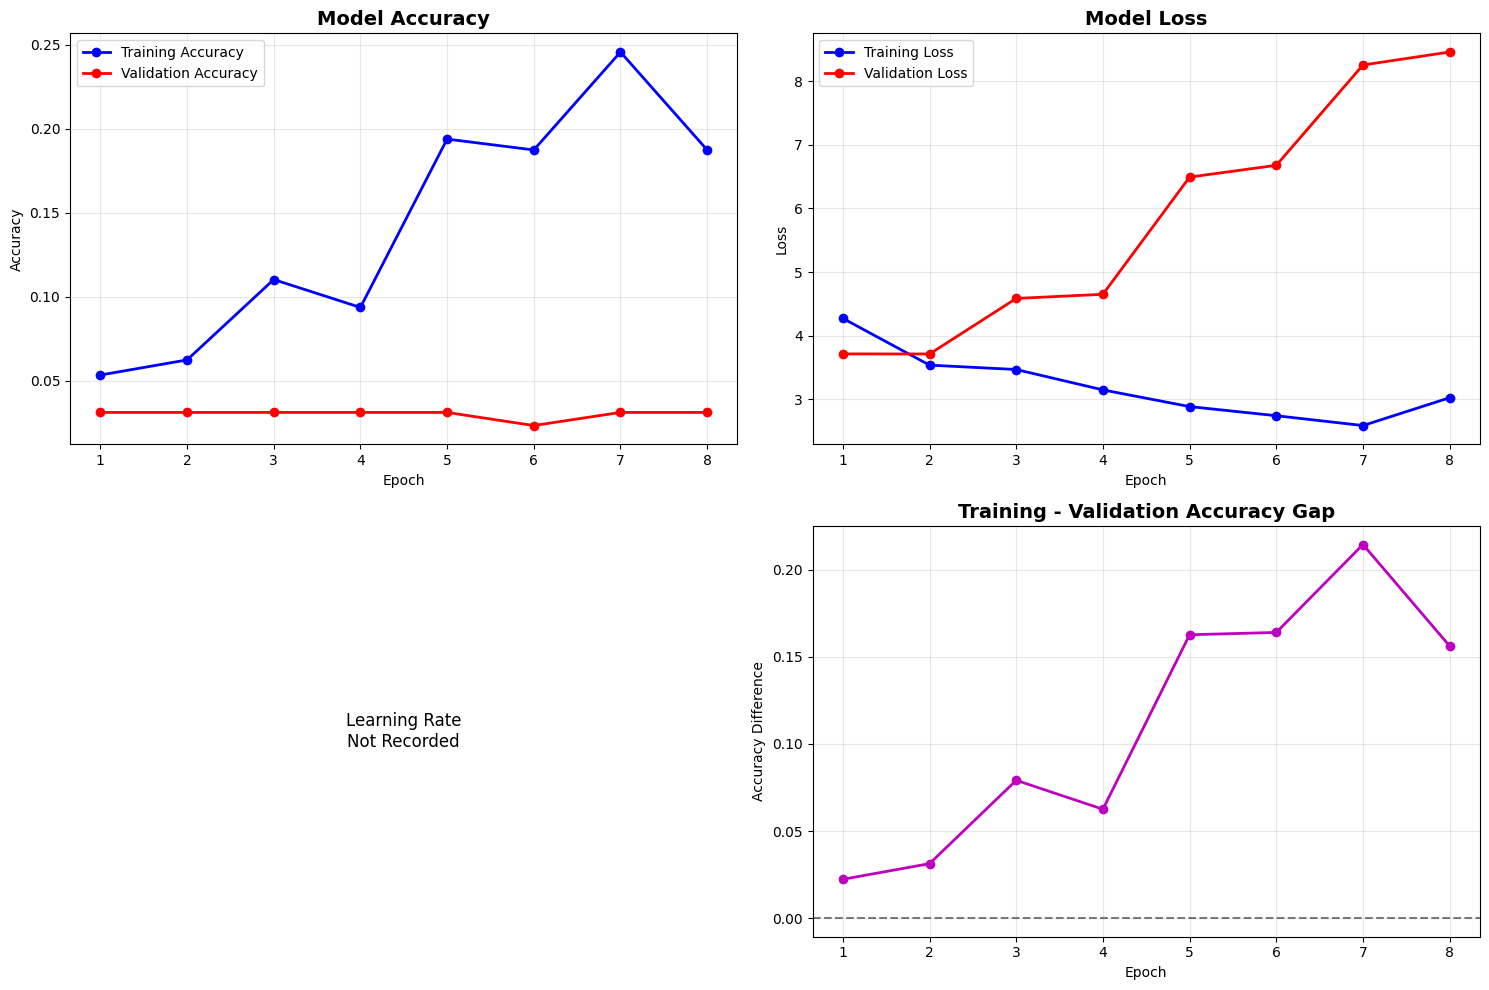

In [44]:
# STEP 13: PLOT TRAINING HISTORY
# ================================================================================

def plot_training_history(history):
    """Plot training and validation metrics"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot accuracy
    ax1.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy', linewidth=2)
    ax1.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot loss
    ax2.plot(epochs, history.history['loss'], 'bo-', label='Training Loss', linewidth=2)
    ax2.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot learning rate (if available)
    if 'lr' in history.history:
        ax3.plot(epochs, history.history['lr'], 'go-', linewidth=2)
        ax3.set_title('Learning Rate', fontweight='bold', fontsize=14)
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3)
    else:
        ax3.axis('off')
        ax3.text(0.5, 0.5, 'Learning Rate\nNot Recorded', ha='center', va='center',
                transform=ax3.transAxes, fontsize=12)

    # Plot accuracy difference
    acc_diff = np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])
    ax4.plot(epochs, acc_diff, 'mo-', linewidth=2)
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.set_title('Training - Validation Accuracy Gap', fontweight='bold', fontsize=14)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy Difference')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

if 'history' in locals():
    plot_training_history(history)
else:
    print("⚠️ Training history not found. Please run the training step first.")

In [45]:
# STEP 14: EVALUATE MODEL ON TEST SET
# ================================================================================

if X is not None and 'history' in locals():
    print("🧪 Evaluating model on test set...")

    # Load the best model (saved by ModelCheckpoint)
    if os.path.exists('best_hand_sign_model.h5'):
        model = load_model('best_hand_sign_model.h5')
        print("📥 Loaded best model from checkpoint")

    # Make predictions on test set
    print("🔮 Making predictions on test data...")
    test_predictions = model.predict(X_test, verbose=1)
    test_pred_classes = np.argmax(test_predictions, axis=1)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, test_pred_classes)
    print(f"🎯 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

    # Generate detailed classification report
    print("\n📋 Detailed Classification Report:")
    class_report = classification_report(
        y_test,
        test_pred_classes,
        target_names=class_names,
        output_dict=True
    )

    # Print classification report
    print(classification_report(y_test, test_pred_classes, target_names=class_names))

    # Show per-class performance
    print(f"\n🏆 Best Performing Classes (by F1-score):")
    f1_scores = [(class_names[i], class_report[class_names[i]]['f1-score'])
                 for i in range(len(class_names))]
    f1_scores_sorted = sorted(f1_scores, key=lambda x: x[1], reverse=True)

    for i, (class_name, f1_score) in enumerate(f1_scores_sorted[:5]):
        print(f"  {i+1}. {class_name}: {f1_score:.4f}")

    if len(f1_scores_sorted) > 5:
        print(f"\n📉 Classes needing improvement:")
        for i, (class_name, f1_score) in enumerate(f1_scores_sorted[-3:]):
            print(f"  {class_name}: {f1_score:.4f}")


🧪 Evaluating model on test set...


📥 Loaded best model from checkpoint
🔮 Making predictions on test data...
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step
🎯 Test Accuracy: 0.0296 (2.96%)

📋 Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         4
           A       0.00      0.00      0.00         4
           B       0.00      0.00      0.00         4
           C       0.00      0.00      0.00         3
           D       0.00      0.00      0.00         4
          

In [47]:
# STEP 15: PLOT CONFUSION MATRIX
# ================================================================================

def plot_confusion_matrix(y_true, y_pred, class_names, normalize=False):
    """Plot confusion matrix with better formatting"""

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'

    # Determine figure size based on number of classes
    fig_size = max(8, len(class_names) * 0.5)
    plt.figure(figsize=(fig_size, fig_size))

    sns.heatmap(
        cm,
        annot=True,
        fmt=fmt,
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        square=True,
        linewidths=0.5
    )

    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show() # Added plt.show() here

🔮 Visualizing prediction results...


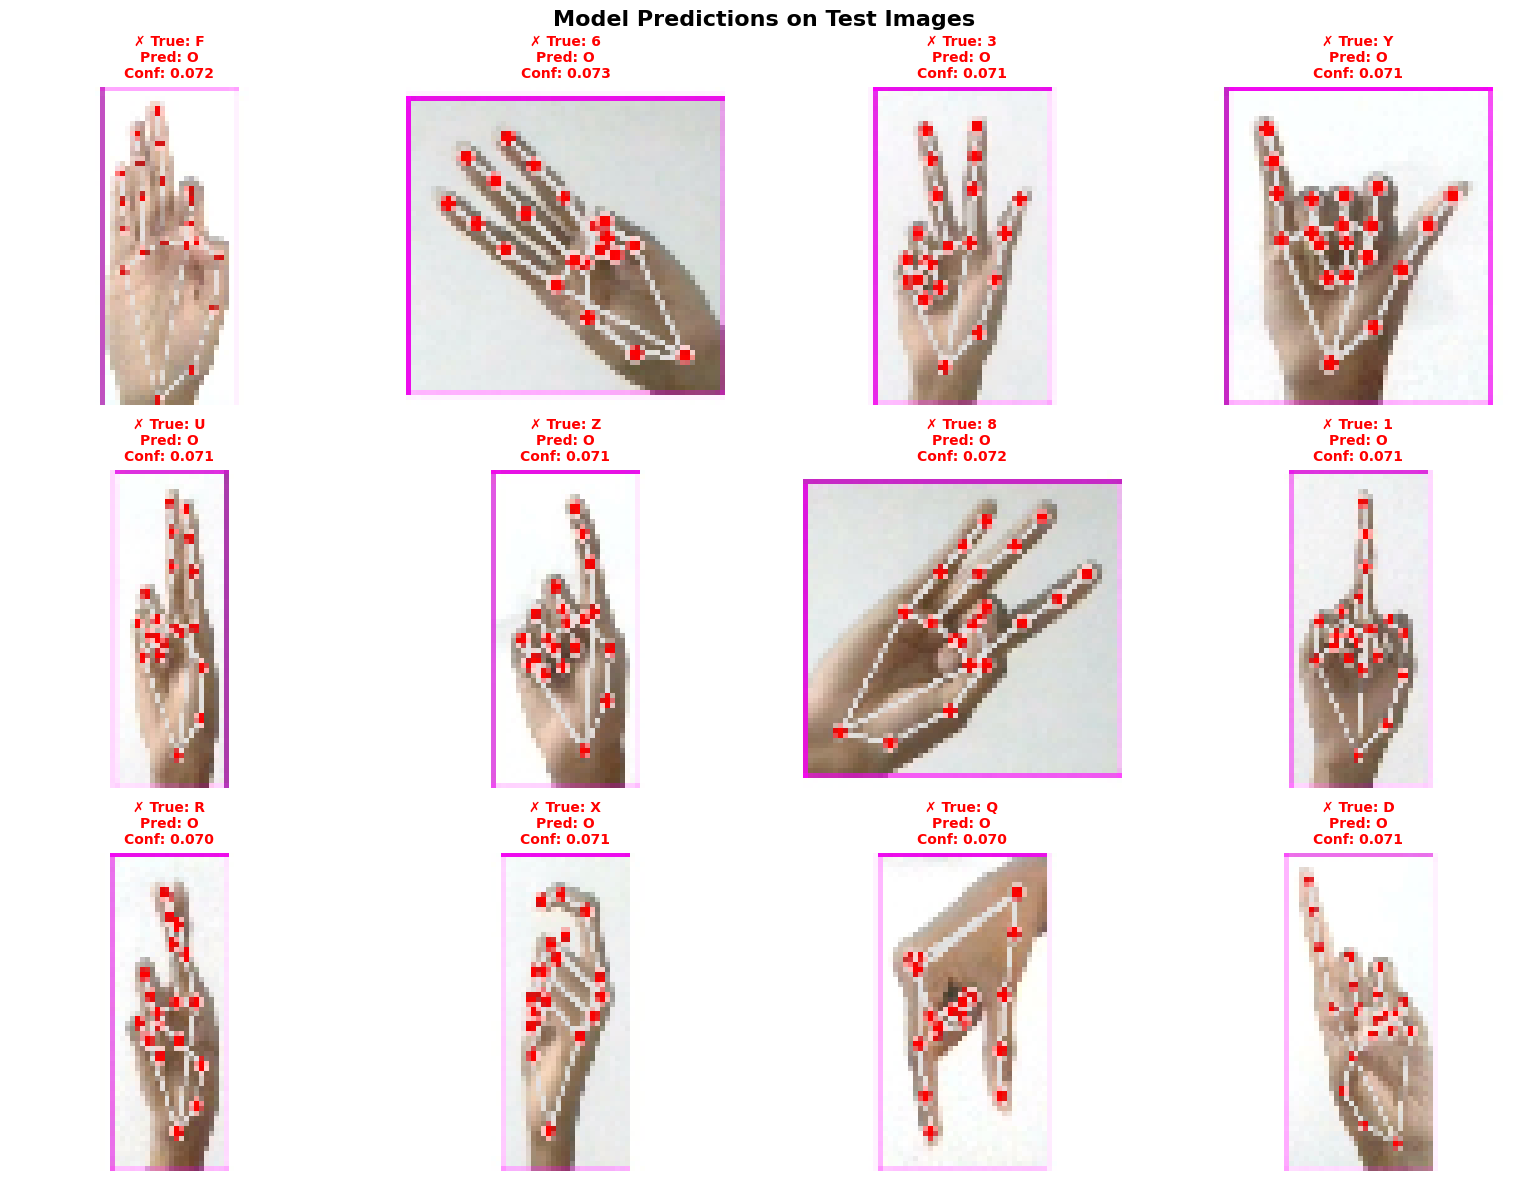

In [48]:
# STEP 16: VISUALIZE PREDICTION RESULTS
# ================================================================================

def visualize_predictions(model, test_images, test_labels, class_names, num_samples=12):
    """Visualize model predictions on test samples"""

    # Get random samples
    indices = np.random.choice(len(test_images), min(num_samples, len(test_images)), replace=False)

    # Calculate grid dimensions
    cols = 4
    rows = (len(indices) + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    for idx, sample_idx in enumerate(indices):
        row, col = idx // cols, idx % cols
        ax = axes[row, col] if rows > 1 else axes[col]

        # Get image and true label
        img = test_images[sample_idx]
        true_label_idx = test_labels[sample_idx]
        true_label = class_names[true_label_idx]

        # Make prediction
        img_batch = np.expand_dims(img, axis=0)
        predictions = model.predict(img_batch, verbose=0)
        predicted_idx = np.argmax(predictions[0])
        predicted_label = class_names[predicted_idx]
        confidence = predictions[0][predicted_idx]

        # Display image
        ax.imshow(img)
        ax.axis('off')

        # Set title with prediction results
        if predicted_label == true_label:
            color = 'green'
            status = '✓'
        else:
            color = 'red'
            status = '✗'

        title = f'{status} True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.3f}'
        ax.set_title(title, color=color, fontsize=10, fontweight='bold')

    # Hide empty subplots
    for idx in range(len(indices), rows * cols):
        row, col = idx // cols, idx % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')

    plt.suptitle('Model Predictions on Test Images', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

if X is not None and 'test_pred_classes' in locals():
    print("🔮 Visualizing prediction results...")
    visualize_predictions(model, X_test, y_test, class_names)


In [51]:
# STEP 17: SAVE THE TRAINED MODEL
# ================================================================================

if X is not None and 'history' in locals():
    print("💾 Saving trained model and metadata...")

    # Save the complete model
    model.save('hand_sign_recognition_final.h5')

    # Save model weights separately
    model.save_weights('hand_sign_weights.weights.h5') # Corrected filename

    # Save model architecture as JSON
    model_json = model.to_json()
    with open('hand_sign_architecture.json', 'w') as json_file:
        json_file.write(model_json)

    # Save metadata
    np.save('class_names.npy', np.array(class_names))
    np.save('label_encoder_classes.npy', label_encoder.classes_)

    # Save training history
    history_dict = {
        'accuracy': history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy'],
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss']
    }
    np.save('training_history.npy', history_dict)

    # Save model configuration
    config = {
        'img_height': IMG_HEIGHT,
        'img_width': IMG_WIDTH,
        'num_classes': num_classes,
        'batch_size': BATCH_SIZE,
        'epochs_trained': len(history.history['accuracy']),
        'final_test_accuracy': test_accuracy if 'test_accuracy' in locals() else None
    }
    np.save('model_config.npy', config)

    print("✅ Model and metadata saved successfully!")
    print("\n📁 Saved files:")
    saved_files = [
        'hand_sign_recognition_final.h5',
        'hand_sign_weights.weights.h5', # Corrected filename
        'hand_sign_architecture.json',
        'class_names.npy',
        'label_encoder_classes.npy',
        'training_history.npy',
        'model_config.npy'
    ]

    for file in saved_files:
        if os.path.exists(file):
            size_mb = os.path.getsize(file) / (1024*1024)
            print(f"  ✅ {file} ({size_mb:.2f} MB)")

💾 Saving trained model and metadata...
✅ Model and metadata saved successfully!

📁 Saved files:
  ✅ hand_sign_recognition_final.h5 (10.88 MB)
  ✅ hand_sign_weights.weights.h5 (10.85 MB)
  ✅ hand_sign_architecture.json (0.02 MB)
  ✅ class_names.npy (0.00 MB)
  ✅ label_encoder_classes.npy (0.00 MB)
  ✅ training_history.npy (0.00 MB)
  ✅ model_config.npy (0.00 MB)


In [53]:
# STEP 18: LOAD MODEL AND MAKE PREDICTIONS ON NEW IMAGES
# ================================================================================

def load_trained_model():
    """Load the complete trained model and metadata"""
    try:
        # Load model
        model = load_model('hand_sign_recognition_final.h5')

        # Load metadata
        class_names = np.load('class_names.npy', allow_pickle=True)
        label_classes = np.load('label_encoder_classes.npy', allow_pickle=True)
        config = np.load('model_config.npy', allow_pickle=True).item()

        print("✅ Model loaded successfully!")
        print(f"  Classes: {len(class_names)}")
        print(f"  Image size: {config['img_height']}x{config['img_width']}")
        if config['final_test_accuracy']:
            print(f"  Test accuracy: {config['final_test_accuracy']:.4f}")

        return model, class_names, config

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, None, None

def predict_single_image(model, image_path, class_names, img_size=(64, 64)):
    """Predict hand sign from a single image"""
    try:
        # Load and preprocess image
        img = load_img(image_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Make prediction
        predictions = model.predict(img_array, verbose=0)

        # Get results
        predicted_class_idx = np.argmax(predictions[0])
        predicted_class = class_names[predicted_class_idx]
        confidence = predictions[0][predicted_class_idx]

        # Get top 3 predictions
        top_3_indices = np.argsort(predictions[0])[-3:][::-1]
        top_3_predictions = [
            (class_names[idx], predictions[0][idx])
            for idx in top_3_indices
        ]

        return predicted_class, confidence, top_3_predictions, img

    except Exception as e:
        print(f"Error predicting image {image_path}: {e}")
        return None, None, None, None

def predict_uploaded_image():
    """Function to predict on uploaded images in Google Colab"""
    try:
        from google.colab import files

        # Load the trained model
        model, class_names, config = load_trained_model()
        if model is None:
            print("❌ Could not load model. Make sure you've trained and saved it first.")
            return

        print("📤 Please upload an image file...")
        uploaded = files.upload()

        for filename, data in uploaded.items():
            print(f"\n🖼️ Analyzing {filename}...")

            # Make prediction
            img_size = (config['img_height'], config['img_width'])
            predicted_class, confidence, top_3, img = predict_single_image(
                model, filename, class_names, img_size
            )

            if predicted_class:
                print(f"🎯 Predicted: {predicted_class}")
                print(f"🔢 Confidence: {confidence:.4f} ({confidence*100:.2f}%)")

                print(f"\n📊 Top 3 predictions:")
                for i, (class_name, conf) in enumerate(top_3):
                    print(f"  {i+1}. {class_name}: {conf:.4f} ({conf*100:.2f}%)")

                # Display the image with prediction
                plt.figure(figsize=(8, 8))
                plt.imshow(img)
                plt.axis('off')
                plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.4f}',
                         fontsize=16, fontweight='bold')
                plt.tight_layout()
                plt.show()
            else:
                print("❌ Could not make prediction on this image")

    except ImportError:
        print("❌ This function requires Google Colab environment")
    except Exception as e:
        print(f"❌ Error: {e}")

# Example usage (uncomment to use):
# predict_uploaded_image()


In [55]:
# STEP 19: BATCH PREDICTION FUNCTION
# ================================================================================

def predict_batch_images(model, image_folder, class_names, img_size=(64, 64)):
    """Predict on multiple images in a folder"""

    if not os.path.exists(image_folder):
        print(f"❌ Folder {image_folder} does not exist")
        return

    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    image_files = [f for f in os.listdir(image_folder)
                  if f.lower().endswith(image_extensions)]

    if not image_files:
        print(f"❌ No image files found in {image_folder}")
        return

    print(f"🔮 Predicting on {len(image_files)} images...")

    results = []
    for img_file in image_files:
        img_path = os.path.join(image_folder, img_file)
        predicted_class, confidence, top_3, img = predict_single_image(
            model, img_path, class_names, img_size
        )

        if predicted_class:
            results.append({
                'filename': img_file,
                'predicted_class': predicted_class,
                'confidence': confidence
            })

    # Display results
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('confidence', ascending=False)

        print(f"\n📊 Prediction Results:")
        print(results_df.to_string(index=False))

        # Show distribution of predictions
        pred_counts = results_df['predicted_class'].value_counts()

        plt.figure(figsize=(12, 6))
        pred_counts.plot(kind='bar', color='skyblue', alpha=0.7)
        plt.title('Distribution of Predictions', fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Class')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        return results_df
    else:
        print("❌ No successful predictions made")
        return None

In [56]:
# STEP 20: PROJECT SUMMARY AND NEXT STEPS
# ================================================================================

if X is not None:
    print("\n" + "="*70)
    print("🎉 HAND SIGN RECOGNITION PROJECT COMPLETED!")
    print("="*70)

    # Project statistics
    print(f"\n📊 Project Statistics:")
    print(f"  Dataset: {len(X)} images across {num_classes} classes")
    print(f"  Training samples: {len(X_train) if 'X_train' in locals() else 'N/A'}")
    print(f"  Model parameters: {model.count_params():,}")

    if 'test_accuracy' in locals():
        print(f"  Final test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

    if 'history' in locals():
        best_val_acc = max(history.history['val_accuracy'])
        print(f"  Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
        print(f"  Training epochs: {len(history.history['accuracy'])}")

    print(f"\n📁 Generated Files:")
    output_files = [
        'hand_sign_recognition_final.h5',
        'best_hand_sign_model.h5',
        'class_names.npy',
        'model_config.npy'
    ]

    for file in output_files:
        if os.path.exists(file):
            size_mb = os.path.getsize(file) / (1024*1024)
            print(f"  ✅ {file} ({size_mb:.2f} MB)")



🎉 HAND SIGN RECOGNITION PROJECT COMPLETED!

📊 Project Statistics:
  Dataset: 900 images across 36 classes
  Training samples: 630
  Model parameters: 2,824,388
  Final test accuracy: 0.0296 (2.96%)
  Best validation accuracy: 0.0312 (3.12%)
  Training epochs: 8

📁 Generated Files:
  ✅ hand_sign_recognition_final.h5 (10.88 MB)
  ✅ best_hand_sign_model.h5 (32.44 MB)
  ✅ class_names.npy (0.00 MB)
  ✅ model_config.npy (0.00 MB)


✅ Model loaded successfully!
  Classes: 36
  Image size: 64x64
  Test accuracy: 0.0296
📤 Please upload an image file...


Saving female-caucasian-hand-gesture-showing-260nw-211930531.webp to female-caucasian-hand-gesture-showing-260nw-211930531.webp

🖼️ Analyzing female-caucasian-hand-gesture-showing-260nw-211930531.webp...
🎯 Predicted: O
🔢 Confidence: 0.0714 (7.14%)

📊 Top 3 predictions:
  1. O: 0.0714 (7.14%)
  2. D: 0.0523 (5.23%)
  3. F: 0.0463 (4.63%)


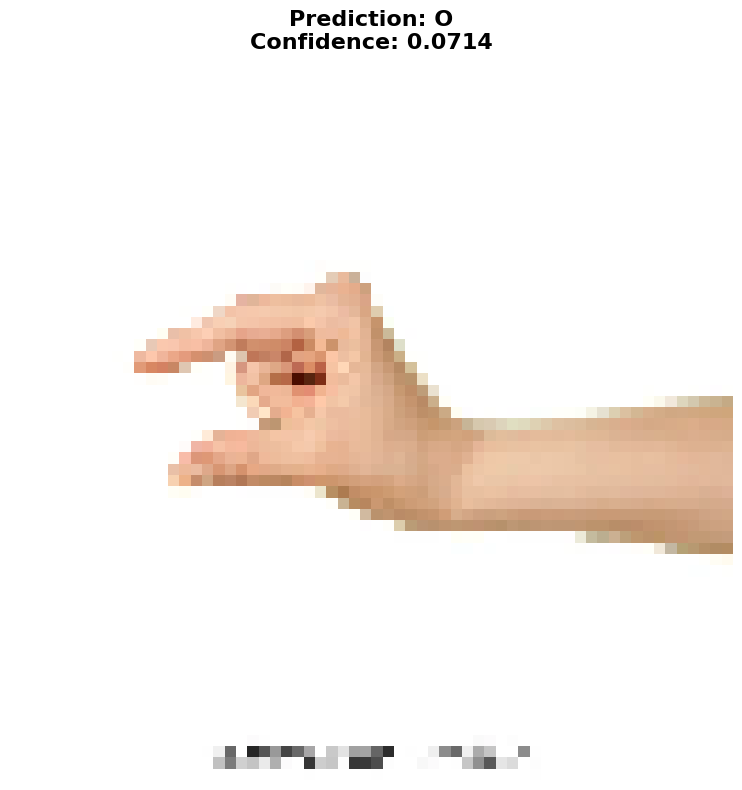

In [58]:
predict_uploaded_image()